<a href="https://colab.research.google.com/drive/1F1rtlQY0vZ9BVTtP7CuvyeBv2hEOpPTo?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



By [Ibrahim Sobh](https://www.linkedin.com/in/ibrahim-sobh-phd-8681757/)

# Image classification with MLP-Mixer and ConvMixer Hybrid models

## Setup and basic code

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

### Data

In [ ]:
num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
# scale data
x_train = x_train / 255.0
x_test = x_test / 255.0

### Model

In [ ]:
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 64 # resize input images to this size.
patch_size = 4  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 4 X 4 = 16 
Patches per image: 256
Elements per patch (3 channels): 48


In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
      print("positional_encoding= ", positional_encoding)
      positions = tf.range(start=0, limit=num_patches, delta=1)
      position_embedding = layers.Embedding(
          input_dim=num_patches, output_dim=embedding_dim #, trainable=True
      )(positions)
      x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc")
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
# patch extraction as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

### Plot

In [ ]:
def plot_curves(history, lossname='loss', accname='acc'):
    plt.figure(figsize=(10, 7))
    plt.plot(history.history[lossname], label='Train')
    plt.plot(history.history['val_' + lossname], label='Val')
    plt.title('Learning curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    print()
    plt.figure(figsize=(10, 7))
    plt.plot(history.history[accname], label='Train')
    plt.plot(history.history['val_' + accname], label='Val')
    plt.title('Learning curve')
    plt.ylabel('acc')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend()
    plt.show()
    print()


def print_exp_params():
    print("num_epochs: ", num_epochs)
    print("embedding_dim: ", embedding_dim)
    print("batch_size: ", batch_size)
    print("num_blocks: ", num_blocks)
    print("dropout_rate: ", dropout_rate)
    print("learning_rate: ", learning_rate)
    print("-"*30)

## MLP-Mixer model

Based on the paper [MLP-Mixer: An all-MLP Architecture for Vision](https://arxiv.org/abs/2105.01601), keras code [code](https://github.com/keras-team/keras-io/blob/master/examples/vision/mlp_image_classification.py)<br>

- "While convolutions and attention are both sufficient for good performance, neither of them is necessary!"
- "Mixer is a competitive but conceptually and technically simple alternative, that does not use convolutions or self-attention"
- "The idea behind the Mixer architecture is to clearly separate the per-location (channel-mixing) operations, and cross-location (token-mixing) operations. Both operations are implemented with MLPs"
- "Mixer relies only on basic matrix multiplication routines, changes to data layout (reshapes and transpositions), and scalar nonlinearities."
- "The computational complexity of the network is linear in the number of input patches, unlike ViT whose complexity is quadratic"
- "Each layer in Mixer takes an input of the same size. This “isotropic” design is most similar to Transformers"
- "Unlike ViTs, Mixer does not use position embeddings because the token-mixing MLPs are sensitive to the order of the input tokens."

The MLP-Mixer model tends to have much less number of parameters compared
to convolutional and transformer-based models, which leads to less training and
serving computational cost.

https://keras.io/examples/vision/mlp_image_classification/#the-mlpmixer-model


### The MLP-Mixer 1 block
> If the input to the layer has a rank greater than 2, then Dense computes the dot product between the inputs and the kernel along the last axis of the inputs and axis 0 of the kernel (using tf.tensordot). 
- For example, if input has dimensions (batch_size, d0, d1), then we create a kernel with shape (d1, units), and the kernel operates along axis 2 of the input, on every sub-tensor of shape (1, 1, d1) (there are batch_size * d0 such sub-tensors). The output in this case will have shape (batch_size, d0, units).

 https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

In [ ]:
# Original paper
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


In [ ]:
num_epochs = 50
embedding_dim = 64
batch_size = 128
num_blocks = 1
dropout_rate = 0.5
mlpmixer_blocks = keras.Sequential([MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)])
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
mlpmixer_classifier.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 64, 64, 3)         7         
_________________________________________________________________
patches_30 (Patches)         (None, 256, 48)           0         
_________________________________________________________________
dense_180 (Dense)            (None, 256, 64)           3136      
_________________________________________________________________
sequential_116 (Sequential)  (None, 256, 64)           164800    
_________________________________________________________________
global_average_pooling1d_18  (None, 64)                0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 64)                0  

In [ ]:
history = run_experiment(mlpmixer_classifier)

Epoch 1/50
352/352 [==============================] - 19s 50ms/step - loss: 1.8038 - acc: 0.3347 - val_loss: 1.5240 - val_acc: 0.4372
Epoch 2/50
352/352 [==============================] - 17s 49ms/step - loss: 1.5425 - acc: 0.4315 - val_loss: 1.8105 - val_acc: 0.4154
Epoch 3/50
352/352 [==============================] - 17s 48ms/step - loss: 1.4457 - acc: 0.4682 - val_loss: 1.4649 - val_acc: 0.4852
Epoch 4/50
352/352 [==============================] - 17s 48ms/step - loss: 1.3750 - acc: 0.4998 - val_loss: 1.4517 - val_acc: 0.5038
Epoch 5/50
352/352 [==============================] - 17s 49ms/step - loss: 1.3089 - acc: 0.5200 - val_loss: 1.6996 - val_acc: 0.4622
Epoch 6/50
352/352 [==============================] - 17s 49ms/step - loss: 1.2535 - acc: 0.5438 - val_loss: 1.5966 - val_acc: 0.4844
Epoch 7/50
352/352 [==============================] - 17s 48ms/step - loss: 1.1992 - acc: 0.5668 - val_loss: 1.5676 - val_acc: 0.5100
Epoch 8/50
352/352 [==============================] - 17s 48ms

num_epochs:  50
embedding_dim:  64
batch_size:  128
num_blocks:  1
dropout_rate:  0.5
learning_rate:  0.005
------------------------------


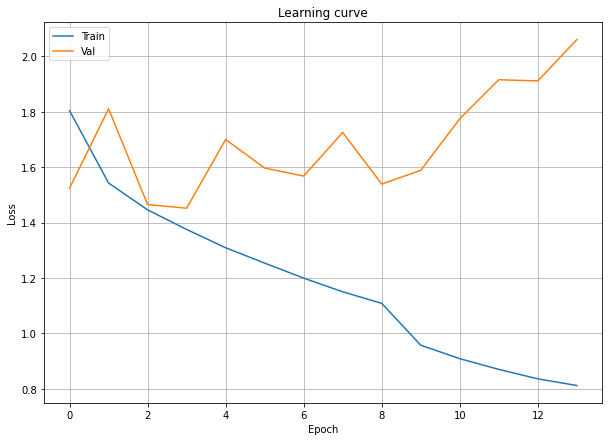

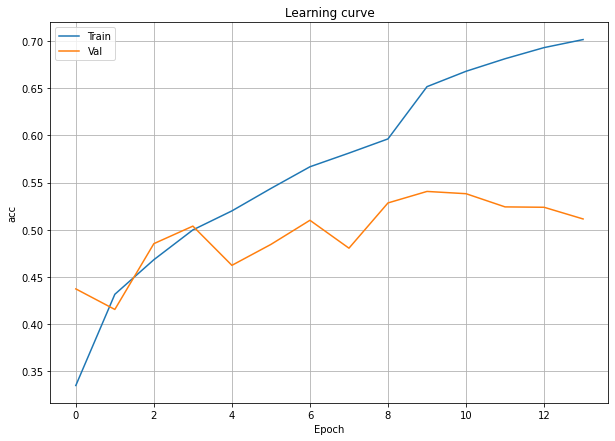

In [ ]:
print_exp_params()
plot_curves(history)

## ConvMixer

Based on the paper [Patches Are All You Need?](https://openreview.net/pdf?id=TVHS5Y4dNvM), keras code [code](https://github.com/tmp-iclr/convmixer/blob/main/convmixer.py)<br>

> Is the performance of ViTs due to the inherently more powerful Transformer architecture, or is it at least partly due to using patches as the input representation.

> ConvMixer, an extremely simple model that is similar in many aspects to the ViT and the even-more-basic MLP-Mixer

> Despite its simplicity, ConvMixer outperforms the ViT, MLP-Mixer, and some of their variants for similar parameter counts and data set sizes, in addition to outperforming classical vision models such as the ResNet.

> While self-attention and MLPs are theoretically more flexible, allowing for large receptive fields and content-aware behavior, the inductive bias of convolution is well-suited to vision tasks and leads to high data efficiency.

> ConvMixers are substantially slower at inference than the competitors!

### ConvMixer 1 block

In [ ]:
# gelu + BatchNormalization
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

# Patch embeddings (using CNN where: kernel_size=patch_size, strides=patch_size)
# followed by gelu + BatchNormalization
def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

# 1) DepthwiseConv2D and then (gelu + BatchNormalization) 
# 2) Skip connection 
# 3) Pointwise convolution and then (gelu + BatchNormalization)  
def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x

# ConvMixer-h/d where:
# h is the width or hidden dimension, 
# d is the depth or the number of repetitions of the ConvMixer layer
def get_conv_mixer_h_d(
    image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    #x = layers.Rescaling(scale=1.0 / 255)(inputs) # data is scaled

    # Extract patch embeddings.
    x = conv_stem(inputs, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)  # should be AdaptiveAvgPool2d?
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

In [ ]:
def run_experiment(model, from_logits=False):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc")
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

In [ ]:
conv_mixer_model = get_conv_mixer_h_d(image_size=32, filters=16, depth=1, kernel_size=5, patch_size=2, num_classes=10)
conv_mixer_model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 16, 16, 16)   208         input_60[0][0]                   
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 16, 16, 16)   0           conv2d_81[0][0]                  
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 16, 16, 16)   64          activation_27[0][0]              
___________________________________________________________________________________________

In [ ]:
num_epochs = 25
history = run_experiment(conv_mixer_model)

Epoch 1/25
352/352 [==============================] - 6s 13ms/step - loss: 1.9899 - acc: 0.2785 - val_loss: 2.2899 - val_acc: 0.1322
Epoch 2/25
352/352 [==============================] - 4s 11ms/step - loss: 1.7765 - acc: 0.3526 - val_loss: 1.9426 - val_acc: 0.2894
Epoch 3/25
352/352 [==============================] - 4s 11ms/step - loss: 1.6997 - acc: 0.3806 - val_loss: 1.7555 - val_acc: 0.3498
Epoch 4/25
352/352 [==============================] - 4s 11ms/step - loss: 1.6415 - acc: 0.4046 - val_loss: 1.6910 - val_acc: 0.3786
Epoch 5/25
352/352 [==============================] - 4s 11ms/step - loss: 1.5980 - acc: 0.4233 - val_loss: 1.6169 - val_acc: 0.4002
Epoch 6/25
352/352 [==============================] - 4s 12ms/step - loss: 1.5587 - acc: 0.4439 - val_loss: 1.5827 - val_acc: 0.4128
Epoch 7/25
352/352 [==============================] - 4s 11ms/step - loss: 1.5252 - acc: 0.4553 - val_loss: 1.7459 - val_acc: 0.3864
Epoch 8/25
352/352 [==============================] - 4s 12ms/step - 

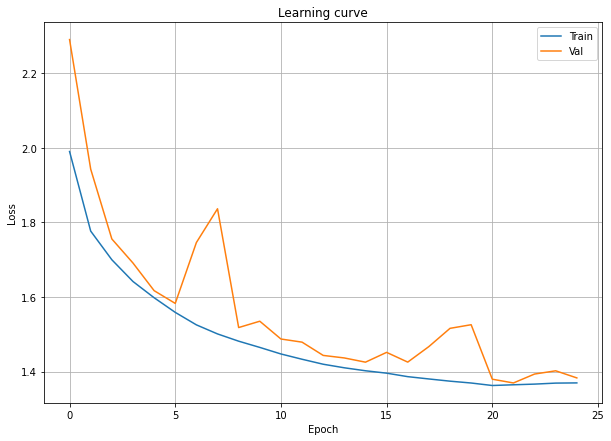

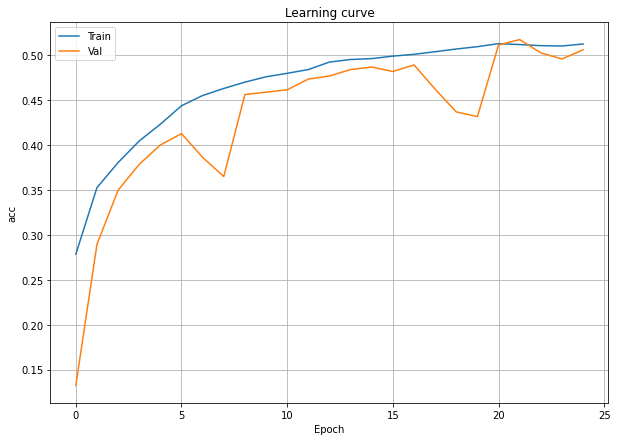

In [ ]:
plot_curves(history)

### Hybrid MLP-Mixer and ConvMixer 

In [ ]:
def build_convmlpmixer_classifier():
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = conv_stem(inputs, filters, patch_size)
    
    #------------------------------
    # ConvMixer: 1 Block 
    #------------------------------
    x0 = patches
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(patches)
    x = layers.Add()([activation_block(x), x0])  # Residual.
    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)
    
    #------------------------------
    # MLP Mixer: 1 Block 
    #------------------------------
    x = layers.Reshape((16 * 16, embedding_dim))(x)
    x = MLPMixerLayer(num_patches, embedding_dim, dropout_rate)(x)

    #------------------------------
    # Apply global average pooling
    #------------------------------ 
    representation = layers.GlobalAveragePooling1D()(x)
    
    #------------------------------
    # Softmax
    #------------------------------ 
    outputs = layers.Dense(num_classes, activation="softmax")(representation)
    
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# MLPMixer
num_epochs = 50
batch_size = 128
embedding_dim = 16
dropout_rate = 0.9
learning_rate = 0.001
weight_decay = 0.0001

# ConvMixer
filters = 16
kernel_size = 5
patch_size = 2

mlpconv_classifier = build_convmlpmixer_classifier()
mlpconv_classifier.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 16, 16, 16)   208         input_68[0][0]                   
__________________________________________________________________________________________________
activation_43 (Activation)      (None, 16, 16, 16)   0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 16, 16, 16)   64          activation_43[0][0]              
___________________________________________________________________________________________

In [ ]:
history = run_experiment(mlpconv_classifier)

Epoch 1/50
352/352 [==============================] - 16s 39ms/step - loss: 1.8110 - acc: 0.3320 - val_loss: 4.7709 - val_acc: 0.1480
Epoch 2/50
352/352 [==============================] - 13s 37ms/step - loss: 1.5244 - acc: 0.4421 - val_loss: 1.6364 - val_acc: 0.4164
Epoch 3/50
352/352 [==============================] - 13s 37ms/step - loss: 1.4522 - acc: 0.4690 - val_loss: 1.5365 - val_acc: 0.4466
Epoch 4/50
352/352 [==============================] - 13s 37ms/step - loss: 1.3927 - acc: 0.4915 - val_loss: 1.4739 - val_acc: 0.4736
Epoch 5/50
352/352 [==============================] - 13s 38ms/step - loss: 1.3532 - acc: 0.5057 - val_loss: 1.4146 - val_acc: 0.4830
Epoch 6/50
352/352 [==============================] - 13s 37ms/step - loss: 1.3189 - acc: 0.5204 - val_loss: 1.5187 - val_acc: 0.4584
Epoch 7/50
352/352 [==============================] - 13s 37ms/step - loss: 1.2943 - acc: 0.5291 - val_loss: 1.3913 - val_acc: 0.5104
Epoch 8/50
352/352 [==============================] - 13s 37ms

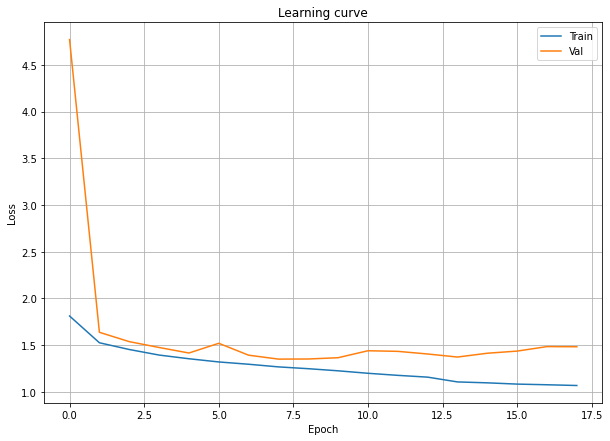

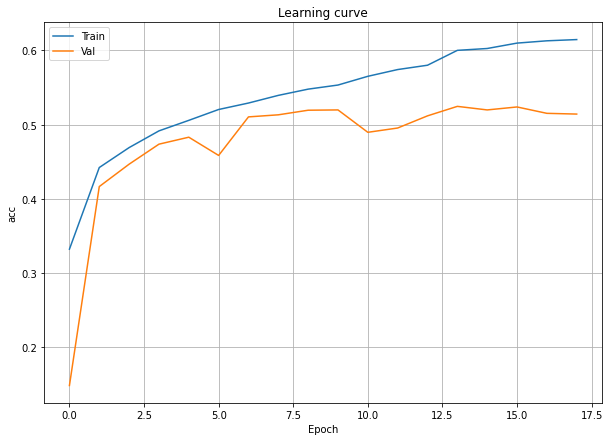

In [ ]:
plot_curves(history)